In [2]:
import h5py
import numpy as np
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets as datasetsgh
import torchvision.transforms as transforms
from torchsummary import summary


import rasterio
from rasterio.transform import Affine

import time
import copy
import sys
import random
import gc

In [5]:
PIL.Image.MAX_IMAGE_PIXELS = None

img_code = "WV01_20120802153817"

tiff_path = f'data/data/orig_tif_files/{img_code}.tif'
img = Image.open(tiff_path)

png_path = f'data/data/orig_png_files/original_{img_code}.png'
img.save(png_path, 'PNG')


In [4]:
PIL.Image.MAX_IMAGE_PIXELS = None
tile_side = 256

# Open the input image
image = Image.open(tiff_path)

img_width, img_height = image.size
print(img_width, img_height)

# Calculate the size of each piece
cols = (img_width + tile_side - 1) // tile_side
rows = (img_height + tile_side - 1) // tile_side
print(cols, rows)

total_tiles = 12348


padded_width = cols * tile_side
padded_height = rows * tile_side
padded_image = Image.new("L", (padded_width, padded_height), (0))

padded_image.paste(image, (0, 0))
print(padded_image.size)

'''
with h5py.File(f'data/data/datasets/entire_{img_code}.h5', 'w') as f:
    
    images = f.create_dataset('images', (total_tiles, tile_side, tile_side), dtype='float32')
    ids = f.create_dataset('ids', (total_tiles, 2), dtype='float32')
    
    idx = 0
    for i in range(rows):
        for j in range(cols):
            # Calculate the boundaries of the piece
            left = j * tile_side
            upper = i * tile_side
            right = left + tile_side
            lower = upper + tile_side

            # Crop the piece from the original image
            img_tile = np.array(padded_image.crop((left, upper, right, lower)))/ 255.0
            
            if np.mean(img_tile) != 0:
                images[idx] = img_tile
                ids[idx] = [i, j]
                idx += 1
    print(idx)
'''

39233 30990
154 122
(39424, 31232)


"\nwith h5py.File(f'data/data/datasets/entire_{img_code}.h5', 'w') as f:\n    \n    images = f.create_dataset('images', (total_tiles, tile_side, tile_side), dtype='float32')\n    ids = f.create_dataset('ids', (total_tiles, 2), dtype='float32')\n    \n    idx = 0\n    for i in range(rows):\n        for j in range(cols):\n            # Calculate the boundaries of the piece\n            left = j * tile_side\n            upper = i * tile_side\n            right = left + tile_side\n            lower = upper + tile_side\n\n            # Crop the piece from the original image\n            img_tile = np.array(padded_image.crop((left, upper, right, lower)))/ 255.0\n            \n            if np.mean(img_tile) != 0:\n                images[idx] = img_tile\n                ids[idx] = [i, j]\n                idx += 1\n    print(idx)\n"

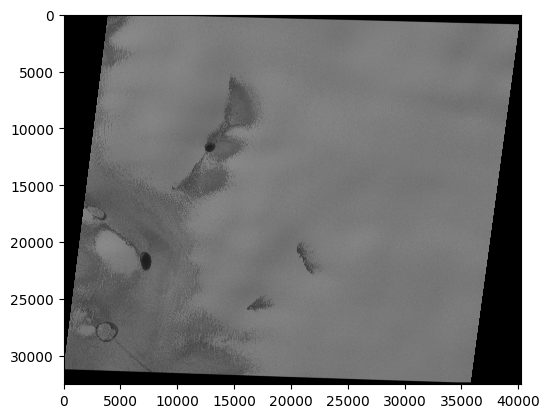

In [79]:
plt.figure()
plt.imshow(padded_image, cmap = "gray")


In [3]:
### CNN ARCHITECTURE ###
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        
    def forward(self,x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))
        
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((F.interpolate(dec4, size=enc4.size()[2:]), enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((F.interpolate(dec3, size=enc3.size()[2:]), enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((F.interpolate(dec2, size=enc2.size()[2:]), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((F.interpolate(dec1, size=enc1.size()[2:]), enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.output_conv(dec1)
        
        return output

In [4]:
### CUSTOM DATASET FOR HDF5 FILE ###
class HDF5Dataset:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = h5py.File(self.file_path, 'r')
        self.images = self.file['images'][:]
        self.ids = self.file['ids'][:]
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        ids = self.ids[idx]
        
        image_tensor = torch.from_numpy(images).unsqueeze(0).float()
        ids_tensor = torch.tensor(ids, dtype=torch.int64)
        
        return {
            'images': image_tensor,
            'ids': ids_tensor
        }
    
    def __del__(self):
        self.file.close()

In [ ]:
data_iter = iter(dataloader)
batch = next(data_iter)

print(batch["images"].shape)

image = batch["images"][25][0]
print(image.shape)

plt.subplot(1,3,1)
plt.imshow(np.asarray(image),cmap='gray')
plt.title("example image")

In [114]:
batch_size = 64
data_file = f'data/data/datasets/entire_{img_code}.h5'
#data_file = '/data/data/datasets/train_dataset.h5'
ds_data = HDF5Dataset(data_file)
dataloader = DataLoader(ds_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
### LOADING MODEL ###
in_channels = 1
out_channels = 2
model = UNet(in_channels, out_channels)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Load the weights
weights_path = '/data/data/model_weights/train_dataset_batch_64_100.pth'
model.load_state_dict(torch.load(weights_path, map_location=device))

# Set to evaluation mode
model.eval()

DataParallel(
  (module): UNet(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [115]:
images_train = []
fractures_pred_train = []
streams_pred_train = []
ids_train = []

with torch.no_grad():
    for batches in dataloader:
        images = batches["images"].to(device)
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        pred_fractures = (pred_fractures > 0.1).float()  # Threshold probabilities to get binary mask
        pred_streams = (pred_streams > 0.25).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        ids_train.append(batches["ids"].numpy())
        
        del images
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
streams_pred_train = np.vstack(streams_pred_train)
ids_train = np.vstack(ids_train)

(17064, 1, 256, 256)
(17064, 1, 256, 256)
(17064, 1, 256, 256)


Text(0.5, 1.0, 'threshold pred, train 4965')

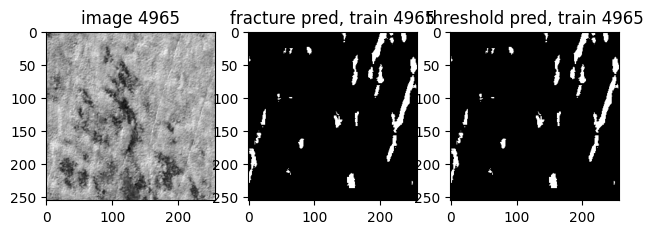

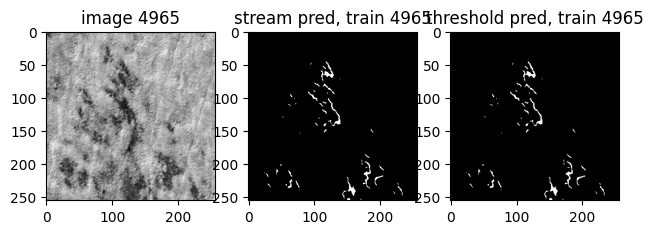

In [94]:
### PLOTTING IMAGES ###

idx_train = random.randint(0,len(fractures_pred_train))
threshold_fractures = 0.1
threshold_streams = 0.25
#idx_train = 627

print(fractures_pred_train.shape)
print(streams_pred_train.shape)
print(images_train.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:] * 255, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(fractures_pred_train[idx_train,0,:,:] * 255,cmap='gray')
plt.title(f'fracture pred, train {idx_train}')
plt.subplot(1,4,3)
thresholded = (fractures_pred_train[idx_train,0,:,:]  > threshold_fractures).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, train {idx_train}')


plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:] * 255, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(streams_pred_train[idx_train,0,:,:] * 255,cmap='gray')
plt.title(f'stream pred, train {idx_train}')
plt.subplot(1,4,3)
thresholded = (streams_pred_train[idx_train,0,:,:] > threshold_streams).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, train {idx_train}')

In [72]:
def create_tiff_from_png(png_path, source_tiff_path, output_tiff_path):
    # Open the source TIFF file to get metadata
    with rasterio.open(source_tiff_path) as src:
        metadata = src.meta.copy()
        transform = src.transform
        crs = src.crs

    png_image = Image.open(png_path).convert('L')  # Convert to grayscale if needed
    png_array = np.array(png_image).astype(np.uint8)
    print(png_array.shape)

    metadata.update({
        'driver': 'GTiff',
        'height': png_array.shape[0],
        'width': png_array.shape[1],
        'count': 1,
        'dtype': png_array.dtype,
        'transform': transform,
        'crs': crs
    })
    
    compression_type = 'lzw'

    # Add the compression option to the metadata
    metadata.update(compress=compression_type)

    # Write the new TIFF file
    with rasterio.open(output_tiff_path, 'w', **metadata) as dst:
        dst.write(png_array, 1)  # Write the image data to band 1

In [116]:
from PIL import Image

fracture_img = Image.new('L', (padded_width, padded_height))
stream_img = Image.new('L', (padded_width, padded_height))

print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    fracture_image = Image.fromarray((255 * fractures_pred_train[i, 0, :, :]))
    stream_image = Image.fromarray((255 * streams_pred_train[i, 0, :, :]))
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))
    
fracture_img.save(f"data/data/maps_from_models/fracture_image_{img_code}.png")
stream_img.save(f"data/data/maps_from_models/stream_image_{img_code}.png")

12348


In [117]:
PIL.Image.MAX_IMAGE_PIXELS = None

source_tiff_path = f"data/data/orig_tif_files/{img_code}.tif"
png_path = f"data/data/maps_from_models/fracture_image_{img_code}.png"
output_tiff_path = f"data/data/maps_from_models/fracture_image_{img_code}.tif"

create_tiff_from_png(png_path, source_tiff_path, output_tiff_path)

png_path = f"data/data/maps_from_models/stream_image_{img_code}.png"
output_tiff_path = f"data/data/maps_from_models/stream_image_{img_code}.tif"

create_tiff_from_png(png_path, source_tiff_path, output_tiff_path)

(33536, 33024)
(33536, 33024)


In [34]:
import os

directory = "data/data/orig_tif_files"

for root, dirs, files in os.walk(directory):
    for filename in files:
        if not filename.startswith('.'):  # Exclude hidden files
            file_path = os.path.join(root, filename)
            image = Image.open(file_path)
            image.save(f'data/data/compressed_tif_files/{filename}', compression="lzw")
